In [1]:
import numpy as np
from PIL import Image
import sys, os
import matplotlib.pyplot as plt
from utils import *
import pickle, random
import theano as T
theano.config.floatX = 'float32'
%matplotlib inline

# ICA Analysis of MNIST

### One layer non-linear network recovers independent components of the covariance matrix

The MNIST image is represented by a vetcor 

$$x \in \Re^d$$

$$L(x,y)=\lVert x^Tx-y^Ty \rVert^2_f + \lambda\sum_{i}\lVert y_{i}\rVert_{1}$$

$$y_{t+1}=ST(x^{T}W_{xy}-y_{t}^TW_{yy,i\neq j}, \eta)$$

An expectation-maximiztion algorithm is performed where the dynamics of the system are allowed to converge to a likely state and then a gradient step is taken down the loss function. Here the next frame is calculated using a scalar constant, fr.

$$fr=0.1$$

$$\hat{y}=(1-fr) y_{t-1} + y_{t}fr$$

$$\frac{\delta L}{\delta W_{yx}}=x^{T}y-y^{2}W_{yx}$$

$$\frac{\delta L}{\delta W_{yy}}=(1+\gamma)y^{T}y-y^{2}W_{yy}$$

Here, $\gamma$, controls the degree of lateral inhibition.

In [7]:
# load data set
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = \
    np.load('mnist.pkl')


/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


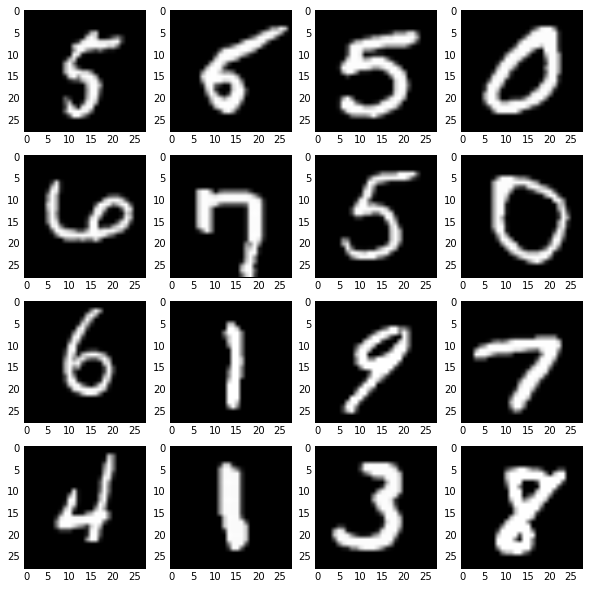

In [8]:
nx= train_x.shape[1]
nex = 16
examples = np.asarray(random.sample(train_x, nex)) # randomly select samples
rc = int(np.sqrt(nex))
fig, ax = plt.subplots(rc, rc, figsize=(10,10))

for i in range(rc):
    for j in range(rc):
        ax[i][j].imshow(examples[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)


/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


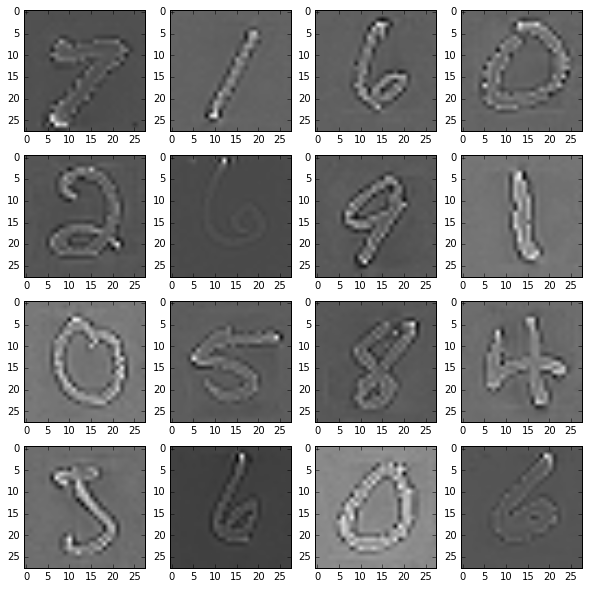

In [10]:
train_x = whiten(train_x)
nx= train_x.shape[1]
nex = 16
examples = np.asarray(random.sample(train_x, nex)) # randomly select samples
rc = int(np.sqrt(nex))
fig, ax = plt.subplots(rc, rc, figsize=(10,10))

for i in range(rc):
    for j in range(rc):
        ax[i][j].imshow(examples[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)


In [12]:
train_x, train_y, valid_x, valid_y, test_x, test_y = [theano.shared(s) for s in 
                                                     [train_x, train_y, valid_x, valid_y, test_x, test_y]]
#train_x = np.nan_to_num((train_x - np.mean(train_x, axis=0))/np.std(train_x, axis=0))

In [22]:
class ICANet:
    def __init__(self):
            self.params = {}
            self.hyper_params = {}
            self.stats = {}
            self.fig_stats = {}
            self.exps = []
            
            
    def run_exp(self, nsamples=50000, nx=train_x.get_value().shape[1], ny=16, tol=10**-3, frames=100, fr=0.1, gamma=1,
               eta=0.1, learning_rule=norm_update, lr=10**-3, exp_name=None, X=train_x):
        
        if exp_name == None:
            exp_name = 'icanet_ny_' + str(ny) + '_gamma_' + str(gamma) + '_learning_rule_' + learning_rule.__name__
        plotres = nsamples/100 if nsamples >= 100 else 1
        
        # init vars
        w_yx = T.shared(rand_ortho(nx, ny))
        w_yy = T.shared(rand_ortho(ny, ny))
        y = T.shared(np.random.rand(ny))
        dw_yx = T.shared(np.zeros((nx, ny)))
        dw_yy = T.shared(np.zeros((ny, ny)))
        y_mask = T.shared(np.ones((ny, ny))-np.eye(ny))
        i = T.tensor.iscalar()
        x = T.tensor.fvector()
        
        #expectation vars and funcs
        yt = st(x.dot(w_yx) - y.dot(w_yy*y_mask), eta)
        ex_updates = OrderedDict({y: (1-fr)*y + fr*yt})
        expectation = T.function([i], [yt], givens={x: X[i]}, updates=ex_updates)

        #maximization vars and funcs
        dw_yx = T.tensor.outer(x, y) - (y**2)*w_yx
        dw_yy = (1+gamma)*T.tensor.outer(y, y) - (y**2)*w_yy
        max_updates = learning_rule({w_yx: dw_yx, w_yy: dw_yy}, lr)
        maximization = T.function([i], [dw_yx, dw_yy], givens={x: X[i]}, updates=max_updates)

        #run em
        steps=[]
        deltas=[]
        Y=[]
        diffs = []
        diffsm = []
        for sample in range(nsamples):

            #expectation
            step = 0
            for f in range(frames):
                step += 1
                yex = expectation(sample)
                #if step%10==0:
                #    print(np.mean(yex))
                #diff = np.sum((y.get_value()-yex)**2)
                #diffm = np.mean((y.get_value()-yex)**2)
                if np.sum((y.get_value()-yex)**2) < tol:
                    break

            #maximization
            if sample%plotres == 0:
                deltas += [maximization(sample)[0]]
                # print(np.linalg.norm(deltas[sample], axis=0))
                steps+=[step]
                Y += [y.get_value()]
                #diffs += [diff]
                #diffsm += [diffm]
            else:
                maximization(sample)
        
        #save exp params
        w_yx, w_yy = w_yx.get_value(), w_yy.get_value()
        self.params[exp_name] = [w_yx, w_yy]
        
        #save stats
        deltas = np.asarray(deltas)
        self.stats[exp_name] = {'Frame Steps': steps, 'dw norm': deltas, 'y': Y}#, ('diffs', diffs), ('diffms', diffsm))
        
        self.hyper_params[exp_name] = {'lr': lr, 'nx': nx, 'ny': ny, 'nsamples': nsamples, 'fr': fr}
        if exp_name not in self.exps:
            self.exps += [exp_name]
        
    def plots(self, exp=None):
        if exp == None:
            exps = self.exps
        else:
            exps = [exp]
            
        for exp in exps:
            #plot fitlers
            filters = self.params[exp][0]
            nx = filters.shape[0]
            ny = filters.shape[1]
            rc=int(np.sqrt(self.hyper_params[exp]['ny']))
            fig, ax = plt.subplots(rc,rc, figsize=(10,10))
            fig.suptitle('Filters: ' + exp)
            for i in range(rc):
                for j in range(rc):
                    ax[i][j].imshow(filters.T[i*rc+j].reshape(nx**0.5, nx**0.5), cmap=plt.cm.gray)
                    
            #plot param inner product matrix
            params = self.params[exp]
            fig, ax = plt.subplots(1, len(params), figsize=(10,10))
            fig.suptitle('Inner Product Matrix: ' + exp)
            for mat, param in enumerate(params):
                ax[mat].imshow(param.T.dot(param), cmap=plt.cm.gray)
                    
            #plot stats
            fig = plt.figure(figsize=(10,5))
            fig.suptitle('Stats: ' + exp)
            stats= self.stats[exp]
            for num, stat in enumerate(stats):
                num += 1
                name, stat = stat, stats[stat]
                stat = np.asarray(stat)
                if len(stat.shape) > 2:
                    for vec in range(ny):
                        fig.add_subplot(1, len(stats), num).plot(np.linalg.norm(stat[:,vec],axis=1))
                else:
                    fig.add_subplot(1, len(stats), num).plot(stat)

                fig.add_subplot(1, len(stats), num).set_title(name)           
            
    

In [25]:
net = ICANet()

for e in [['.2', 0.2], ['.5', 0.5], ['1', 1]]:
    for g in [['1', 1]]:
        net.run_exp(nsamples=10000, gamma=g[1], exp_name=g[0] + e[0], tol=10**-4, eta=e[1])

/home/cbybee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:97: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


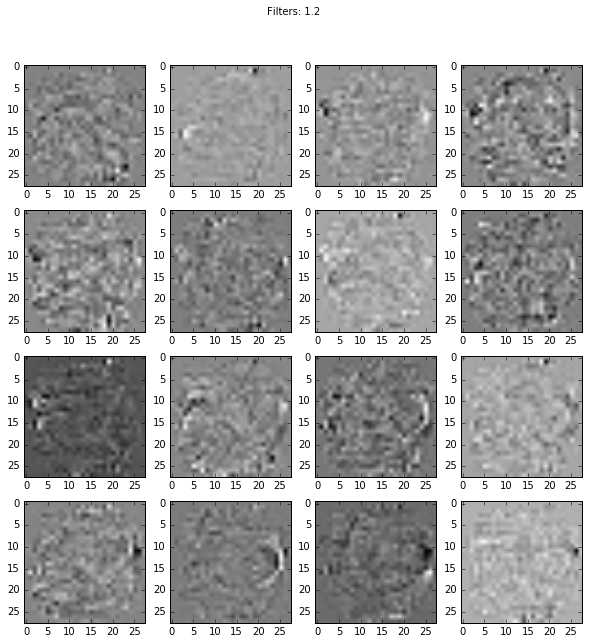

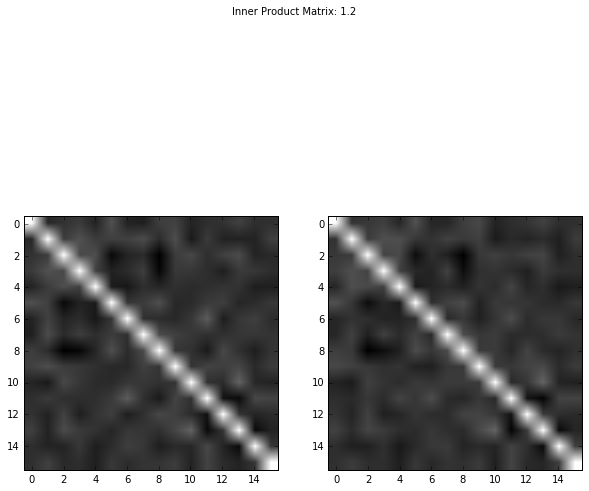

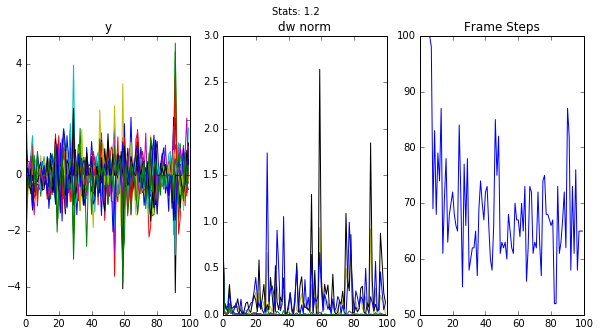

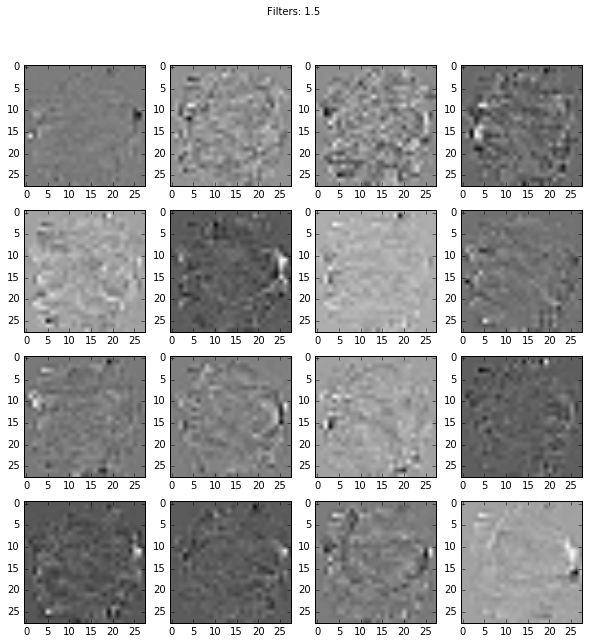

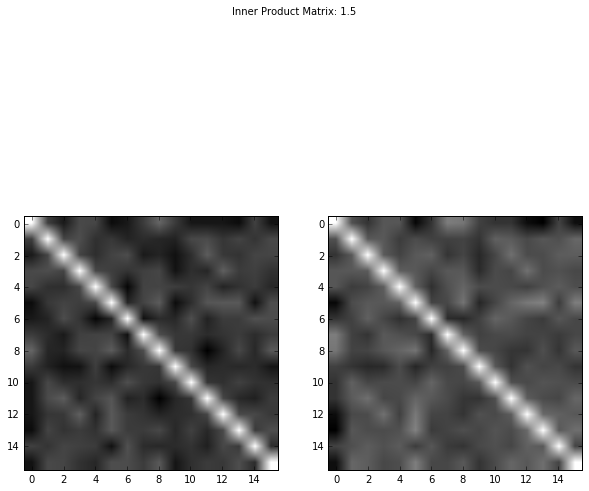

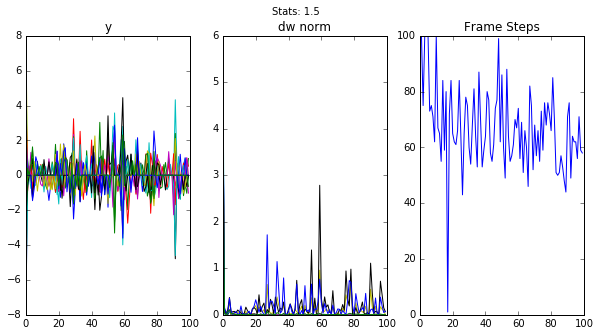

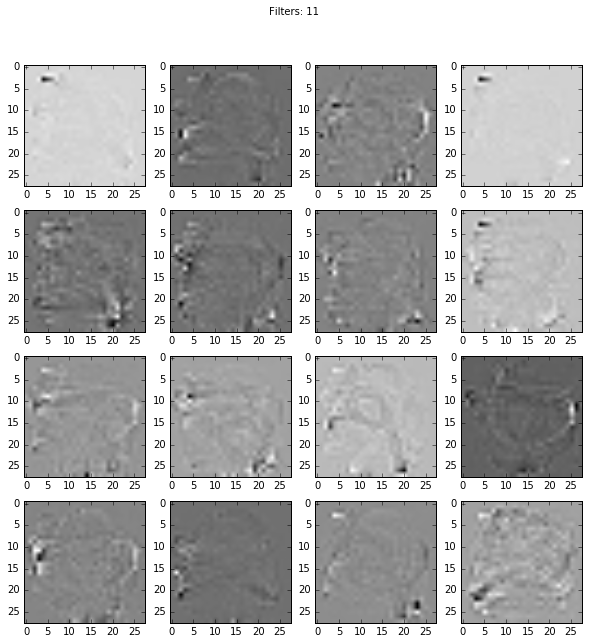

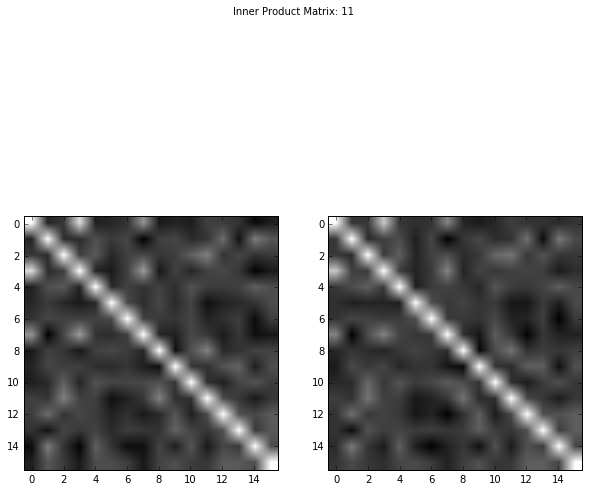

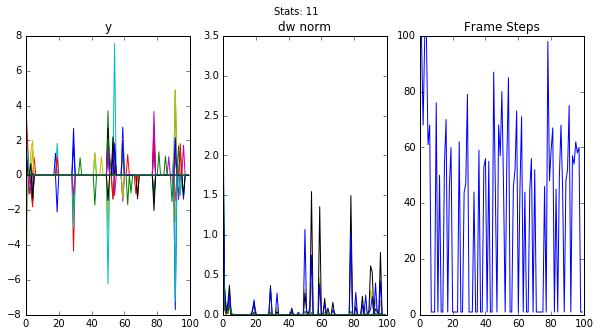

In [26]:
net.plots()